### <b>Part II: Implementing ResNet Architecture</b>

In this part implement ResNet-18 by manually defining a residual block and apply it to solve an image dataset that we use in Part I.<br>
The expected accuracy for this part is more than 75% without optimization techniques and 80% with optimization techniques.

In [1]:
# First we will try to import the normalized data that we exported
# in PART 1

# Importing necessary libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Mounting Google Drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pickle

# Loading the dataset
# Using pickle

with open('/content/drive/MyDrive/Datasets/dataset_dl_Part1.pkl', 'rb') as f:
    normalized_data_images, integer_labels = pickle.load(f)

In [5]:
# Now that we are done with data loading, pre-processing, analysis
# and visualization - its time to divide the dataset
# into training, validation and testing dataset components

from sklearn.model_selection import train_test_split

# Splitting the dataset into a combined training and testing set (90%) and a validation set (10%)
X_train_valid, X_test, y_train_valid, y_test = train_test_split(normalized_data_images, integer_labels, test_size=0.10, random_state=42)

# Further splitting the combined training and testing set into a training set (80%) and a validation set (10%)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_valid, y_train_valid, test_size=0.1111, random_state=42)

In [6]:
# Printing the sizes of the resulting sets

print("Training set size (X_train):", X_train.shape)
print("Validation set size (X_valid):", X_valid.shape)
print("Testing set size (X_test):", X_test.shape)
print("\n")
print("Training set size (y_train):", y_train.shape)
print("Validation set size (y_valid):", y_valid.shape)
print("Testing set size (y_test):", y_test.shape)

Training set size (X_train): (24000, 64, 64, 3)
Validation set size (X_valid): (3000, 64, 64, 3)
Testing set size (X_test): (3000, 64, 64, 3)


Training set size (y_train): (24000,)
Validation set size (y_valid): (3000,)
Testing set size (y_test): (3000,)


### <b>STEPS :</b>

1. Implement residual blocks of ResNet, including convolutional layers, batch
normalization, ReLU activation, and residual connections. You can use nn.Conv2d,
nn.BatchNorm2d, nn.Sequential, nn.Identity.

In [51]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Define the residual block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.identity_downsample = nn.Identity()
        if stride != 1 or in_channels != out_channels:
            self.identity_downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = self.identity_downsample(x)
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += identity
        out = self.relu(out)
        return out

<br>
<br>

2. Design a Resnet-18 model: configuration with 18-layer

In [52]:
# Define the ResNet-18 model
class ResNet18(nn.Module):
    def __init__(self, num_classes):
        super(ResNet18, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self.make_layer(64, 64, blocks=2)
        self.layer2 = self.make_layer(64, 128, blocks=2, stride=2)
        self.layer3 = self.make_layer(128, 256, blocks=2, stride=2)
        self.layer4 = self.make_layer(256, 512, blocks=2, stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def make_layer(self, in_channels, out_channels, blocks, stride=1):
        layers = []
        layers.append(ResidualBlock(in_channels, out_channels, stride))
        for _ in range(1, blocks):
            layers.append(ResidualBlock(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)  # conv2_x
        x = self.layer2(x)  # conv3_x
        x = self.layer3(x)  # conv4_x
        x = self.layer4(x)  # conv5_x

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

In [53]:
# Instantiating the model
num_classes = 3  # Number of classes
model_base = ResNet18(num_classes).cuda()

In [54]:
# Checking if CUDA (GPU support) is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [55]:
# Printing the model architecture
print(model_base)

ResNet18(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (identity_downsample): Identity()
    )
    (1): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running

In [56]:
!pip install torchinfo

from torchinfo import summary

summary(model_base, (64, 3, 64, 64))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet18                                 [64, 3]                   --
├─Conv2d: 1-1                            [64, 64, 32, 32]          9,408
├─BatchNorm2d: 1-2                       [64, 64, 32, 32]          128
├─ReLU: 1-3                              [64, 64, 32, 32]          --
├─MaxPool2d: 1-4                         [64, 64, 16, 16]          --
├─Sequential: 1-5                        [64, 64, 16, 16]          --
│    └─ResidualBlock: 2-1                [64, 64, 16, 16]          --
│    │    └─Identity: 3-1                [64, 64, 16, 16]          --
│    │    └─Conv2d: 3-2                  [64, 64, 16, 16]          36,864
│    │    └─BatchNorm2d: 3-3             [64, 64, 16, 16]          128
│    │    └─ReLU: 3-4                    [64, 64, 16, 16]          --
│    │    └─Conv2d: 3-5                  [64, 64, 16, 16]          36,864
│    │    └─BatchNorm2d: 3-6             [64, 64, 16, 16]          128
│

<br>
<br>

3. Train the model on the dataset that you used in Part I. For your dataset, adjust the size, e.g. for the input and the output layers.

In [57]:
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score

# Training the model on the dataset splitted

# Defining the dataset and dataloaders for training, validation, and testing

# The model shall only accept 3 channels (RGB), thus need to reshape
# accordingly
X_train = X_train.reshape(24000, 3, 64, 64)
X_valid = X_valid.reshape(3000, 3, 64, 64)
X_test = X_test.reshape(3000, 3, 64, 64)

from torch.utils.data import DataLoader, TensorDataset

train_dataset = TensorDataset(torch.Tensor(X_train), torch.LongTensor(y_train))
valid_dataset = TensorDataset(torch.Tensor(X_valid), torch.LongTensor(y_valid))
test_dataset = TensorDataset(torch.Tensor(X_test), torch.LongTensor(y_test))

# Creating data loaders for training, validation and testing components

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=64)

In [58]:
# Defining loss function and optimizer
criterion_base = nn.CrossEntropyLoss()
optimizer_base = optim.Adam(model_base.parameters(), lr=0.001)

In [59]:
# Training the model
num_epochs = 10

train_losses_base = []
train_accuracies_base = []
valid_losses_base = []
valid_accuracies_base = []

for epoch in range(num_epochs):
    model_base.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for inputs, labels in train_loader:
        optimizer_base.zero_grad()
        inputs, labels = inputs.to(device), labels.to(device)  # Moving data to GPU
        outputs = model_base(inputs)
        loss = criterion_base(outputs, labels)
        loss.backward()
        optimizer_base.step()
        running_loss += loss.item() * inputs.size(0)

        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader.dataset)
    train_accuracy = correct_train / total_train
    train_losses_base.append(epoch_loss)
    train_accuracies_base.append(train_accuracy)

    # Validation
    model_base.eval()
    valid_loss = 0.0
    correct_valid = 0
    total_valid = 0
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Moving data to GPU
            outputs = model_base(inputs)
            loss = criterion_base(outputs, labels)
            valid_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total_valid += labels.size(0)
            correct_valid += (predicted == labels).sum().item()

    epoch_valid_loss = valid_loss / len(valid_loader.dataset)
    valid_accuracy = correct_valid / total_valid
    valid_losses_base.append(epoch_valid_loss)
    valid_accuracies_base.append(valid_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Loss: {epoch_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
          f"Valid Loss: {epoch_valid_loss:.4f}, Valid Accuracy: {valid_accuracy:.4f}")

Epoch 1/10, Train Loss: 0.5947, Train Accuracy: 0.7622, Valid Loss: 0.9898, Valid Accuracy: 0.7037
Epoch 2/10, Train Loss: 0.4607, Train Accuracy: 0.8172, Valid Loss: 0.6493, Valid Accuracy: 0.7290
Epoch 3/10, Train Loss: 0.4120, Train Accuracy: 0.8379, Valid Loss: 0.4321, Valid Accuracy: 0.8437
Epoch 4/10, Train Loss: 0.3840, Train Accuracy: 0.8498, Valid Loss: 0.3733, Valid Accuracy: 0.8587
Epoch 5/10, Train Loss: 0.3609, Train Accuracy: 0.8550, Valid Loss: 0.3811, Valid Accuracy: 0.8623
Epoch 6/10, Train Loss: 0.3437, Train Accuracy: 0.8654, Valid Loss: 0.4205, Valid Accuracy: 0.8357
Epoch 7/10, Train Loss: 0.3225, Train Accuracy: 0.8735, Valid Loss: 0.3835, Valid Accuracy: 0.8467
Epoch 8/10, Train Loss: 0.3111, Train Accuracy: 0.8793, Valid Loss: 0.3613, Valid Accuracy: 0.8630
Epoch 9/10, Train Loss: 0.2980, Train Accuracy: 0.8802, Valid Loss: 0.4976, Valid Accuracy: 0.8163
Epoch 10/10, Train Loss: 0.2724, Train Accuracy: 0.8920, Valid Loss: 0.5502, Valid Accuracy: 0.7790


In [60]:
# Testing the model

test_losses_base = []
test_accuracies_base = []
test_predicted_labels_base = []
test_true_labels_base = []

# Testing loop
model_base.eval()
running_loss = 0.0
correct_test = 0
total_test = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.cuda(), labels.cuda()  # Moving data to GPU
        outputs = model_base(inputs)
        labels = labels.to(torch.int64)
        loss = criterion_base(outputs, labels)
        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

        test_predicted_labels_base.extend(predicted.cpu().numpy())
        test_true_labels_base.extend(labels.cpu().numpy())

test_loss = running_loss / len(test_loader)
test_accuracy = 100 * correct_test / total_test

print(f"Test Loss: {test_loss:.4f} - Test Acc: {test_accuracy:.2f}%")

test_losses_base.append(test_loss)
test_accuracies_base.append(test_accuracy)

Test Loss: 0.5526 - Test Acc: 78.37%


<br>
<br>

4. Apply at least two techniques to prevent overfitting and improve the results.

In [61]:
'''
TECHNIQUE 1 : L2 Regularization
'''

# Instantiating the model
model_1 = ResNet18(num_classes).cuda()

# Defining loss function
criterion_1 = nn.CrossEntropyLoss()

# Define optimizer with L2 regularization
optimizer_1 = optim.Adam(model_1.parameters(), lr=0.001, weight_decay = 0.0001)

In [62]:
# Training the model
num_epochs = 10

train_losses_1 = []
train_accuracies_1 = []
valid_losses_1 = []
valid_accuracies_1 = []

for epoch in range(num_epochs):
    model_1.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for inputs, labels in train_loader:
        optimizer_1.zero_grad()
        inputs, labels = inputs.to(device), labels.to(device)  # Moving data to GPU
        outputs = model_1(inputs)
        loss = criterion_1(outputs, labels)
        loss.backward()
        optimizer_1.step()
        running_loss += loss.item() * inputs.size(0)

        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader.dataset)
    train_accuracy = correct_train / total_train
    train_losses_1.append(epoch_loss)
    train_accuracies_1.append(train_accuracy)

    # Validation
    model_1.eval()
    valid_loss = 0.0
    correct_valid = 0
    total_valid = 0
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Moving data to GPU
            outputs = model_1(inputs)
            loss = criterion_1(outputs, labels)
            valid_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total_valid += labels.size(0)
            correct_valid += (predicted == labels).sum().item()

    epoch_valid_loss = valid_loss / len(valid_loader.dataset)
    valid_accuracy = correct_valid / total_valid
    valid_losses_1.append(epoch_valid_loss)
    valid_accuracies_1.append(valid_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Loss: {epoch_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
          f"Valid Loss: {epoch_valid_loss:.4f}, Valid Accuracy: {valid_accuracy:.4f}")

Epoch 1/10, Train Loss: 0.6226, Train Accuracy: 0.7450, Valid Loss: 0.5302, Valid Accuracy: 0.7960
Epoch 2/10, Train Loss: 0.4807, Train Accuracy: 0.8089, Valid Loss: 0.7871, Valid Accuracy: 0.6800
Epoch 3/10, Train Loss: 0.4332, Train Accuracy: 0.8296, Valid Loss: 0.5131, Valid Accuracy: 0.8060
Epoch 4/10, Train Loss: 0.4003, Train Accuracy: 0.8425, Valid Loss: 0.4305, Valid Accuracy: 0.8217
Epoch 5/10, Train Loss: 0.3793, Train Accuracy: 0.8522, Valid Loss: 0.3996, Valid Accuracy: 0.8433
Epoch 6/10, Train Loss: 0.3602, Train Accuracy: 0.8581, Valid Loss: 0.3978, Valid Accuracy: 0.8407
Epoch 7/10, Train Loss: 0.3466, Train Accuracy: 0.8653, Valid Loss: 0.4577, Valid Accuracy: 0.8140
Epoch 8/10, Train Loss: 0.3369, Train Accuracy: 0.8696, Valid Loss: 0.7267, Valid Accuracy: 0.7113
Epoch 9/10, Train Loss: 0.3293, Train Accuracy: 0.8722, Valid Loss: 0.4690, Valid Accuracy: 0.8063
Epoch 10/10, Train Loss: 0.3199, Train Accuracy: 0.8769, Valid Loss: 0.4740, Valid Accuracy: 0.8163


In [63]:
# Testing the model

test_losses_1 = []
test_accuracies_1 = []
test_predicted_labels_1 = []
test_true_labels_1 = []

# Testing loop
model_1.eval()
running_loss = 0.0
correct_test = 0
total_test = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.cuda(), labels.cuda()  # Moving data to GPU
        outputs = model_1(inputs)
        labels = labels.to(torch.int64)
        loss = criterion_1(outputs, labels)
        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

        test_predicted_labels_1.extend(predicted.cpu().numpy())
        test_true_labels_1.extend(labels.cpu().numpy())

test_loss = running_loss / len(test_loader)
test_accuracy = 100 * correct_test / total_test

print(f"Test Loss: {test_loss:.4f} - Test Acc: {test_accuracy:.2f}%")

test_losses_1.append(test_loss)
test_accuracies_1.append(test_accuracy)

Test Loss: 0.4683 - Test Acc: 81.83%


In [64]:
'''
TECHNIQUE 2 : DROPOUT LAYERS BETWEEN FC LAYERS
'''

# Defining the residual block
class ResidualBlock_Dropout(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock_Dropout, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.identity_downsample = nn.Identity()
        if stride != 1 or in_channels != out_channels:
            self.identity_downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = self.identity_downsample(x)
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += identity
        out = self.relu(out)
        return out

In [65]:
# Defining the ResNet-18 model
class ResNet18_DropOut(nn.Module):
    def __init__(self, num_classes, dropout_rate=0.5):  # Adding dropout_rate argument
        super(ResNet18_DropOut, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self.make_layer(64, 64, blocks=2)
        self.layer2 = self.make_layer(64, 128, blocks=2, stride=2)
        self.layer3 = self.make_layer(128, 256, blocks=2, stride=2)
        self.layer4 = self.make_layer(256, 512, blocks=2, stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        # Dropout layer added
        self.dropout = nn.Dropout(dropout_rate)

        self.fc = nn.Linear(512, num_classes)

    def make_layer(self, in_channels, out_channels, blocks, stride=1):
        layers = []
        layers.append(ResidualBlock_Dropout(in_channels, out_channels, stride))
        for _ in range(1, blocks):
            layers.append(ResidualBlock_Dropout(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)  # conv2_x
        x = self.layer2(x)  # conv3_x
        x = self.layer3(x)  # conv4_x
        x = self.layer4(x)  # conv5_x

        x = self.avgpool(x)
        x = torch.flatten(x, 1)

        # Applying dropout
        x = self.dropout(x)

        x = self.fc(x)
        return x

In [66]:
# Instantiating the model
model_2 = ResNet18_DropOut(num_classes).cuda()

# Defining loss function
criterion_2 = nn.CrossEntropyLoss()

# Define optimizer with L2 regularization
optimizer_2 = optim.Adam(model_2.parameters(), lr=0.001, weight_decay = 0.0001)

In [67]:
# Training the model
num_epochs = 10

train_losses_2 = []
train_accuracies_2 = []
valid_losses_2 = []
valid_accuracies_2 = []

for epoch in range(num_epochs):
    model_2.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for inputs, labels in train_loader:
        optimizer_2.zero_grad()
        inputs, labels = inputs.to(device), labels.to(device)  # Moving data to GPU
        outputs = model_2(inputs)
        loss = criterion_2(outputs, labels)
        loss.backward()
        optimizer_2.step()
        running_loss += loss.item() * inputs.size(0)

        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader.dataset)
    train_accuracy = correct_train / total_train
    train_losses_2.append(epoch_loss)
    train_accuracies_2.append(train_accuracy)

    # Validation
    model_2.eval()
    valid_loss = 0.0
    correct_valid = 0
    total_valid = 0
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Moving data to GPU
            outputs = model_2(inputs)
            loss = criterion_2(outputs, labels)
            valid_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total_valid += labels.size(0)
            correct_valid += (predicted == labels).sum().item()

    epoch_valid_loss = valid_loss / len(valid_loader.dataset)
    valid_accuracy = correct_valid / total_valid
    valid_losses_2.append(epoch_valid_loss)
    valid_accuracies_2.append(valid_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Loss: {epoch_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
          f"Valid Loss: {epoch_valid_loss:.4f}, Valid Accuracy: {valid_accuracy:.4f}")

Epoch 1/10, Train Loss: 0.6260, Train Accuracy: 0.7485, Valid Loss: 1.0514, Valid Accuracy: 0.5593
Epoch 2/10, Train Loss: 0.4764, Train Accuracy: 0.8114, Valid Loss: 0.4161, Valid Accuracy: 0.8423
Epoch 3/10, Train Loss: 0.4302, Train Accuracy: 0.8314, Valid Loss: 0.4084, Valid Accuracy: 0.8443
Epoch 4/10, Train Loss: 0.4003, Train Accuracy: 0.8424, Valid Loss: 0.3997, Valid Accuracy: 0.8447
Epoch 5/10, Train Loss: 0.3787, Train Accuracy: 0.8520, Valid Loss: 0.5484, Valid Accuracy: 0.7940
Epoch 6/10, Train Loss: 0.3693, Train Accuracy: 0.8564, Valid Loss: 0.9395, Valid Accuracy: 0.6530
Epoch 7/10, Train Loss: 0.3528, Train Accuracy: 0.8611, Valid Loss: 0.5135, Valid Accuracy: 0.8060
Epoch 8/10, Train Loss: 0.3378, Train Accuracy: 0.8690, Valid Loss: 0.4447, Valid Accuracy: 0.8243
Epoch 9/10, Train Loss: 0.3229, Train Accuracy: 0.8747, Valid Loss: 1.1035, Valid Accuracy: 0.6620
Epoch 10/10, Train Loss: 0.3154, Train Accuracy: 0.8771, Valid Loss: 0.3804, Valid Accuracy: 0.8583


In [68]:
# Testing the model

test_losses_2 = []
test_accuracies_2 = []
test_predicted_labels_2 = []
test_true_labels_2 = []

# Testing loop
model_2.eval()
running_loss = 0.0
correct_test = 0
total_test = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.cuda(), labels.cuda()  # Moving data to GPU
        outputs = model_2(inputs)
        labels = labels.to(torch.int64)
        loss = criterion_2(outputs, labels)
        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

        test_predicted_labels_2.extend(predicted.cpu().numpy())
        test_true_labels_2.extend(labels.cpu().numpy())

test_loss = running_loss / len(test_loader)
test_accuracy = 100 * correct_test / total_test

print(f"Test Loss: {test_loss:.4f} - Test Acc: {test_accuracy:.2f}%")

test_losses_2.append(test_loss)
test_accuracies_2.append(test_accuracy)

Test Loss: 0.3742 - Test Acc: 85.67%


<br>
<br>

8. Save the weights of the trained neural network that provides the best results. Check
saving and loading models (PyTorch)

In [69]:
# As of now we can conclude that MODEL-2 (Only with L2 regularization)
# Performed the best - thus, we are going to save the MODEL-2

torch.save(model_2.state_dict(), 'best_model_(model_2)_dl_a0_part2.pth')

<br>
<br>

9. Discuss the results and provide relevant graphs:<br>
• Report training accuracy, training loss, validation accuracy, validation loss, testing accuracy, and testing loss.<br>
• Plot the training and validation accuracy over time (epochs).<br>
• Plot the training and validation loss over time (epochs).<br>
• Generate a confusion matrix using the model's predictions on the test set.<br>
• Calculate and report other evaluation metrics such as Precision, recall and F1 score (more details). You can use sklearn.metrics.recision_recall_fscore_support

In [70]:
'''
Report training accuracy, training loss, validation accuracy, validation loss, testing accuracy, and testing loss
'''

# After training and testing for all the models

print("BASE MODEL 🔻\n")
print("Training Accuracy:", train_accuracies_base)
print("Training Loss:", train_losses_base)
print("Validation Accuracy:", valid_accuracies_base)
print("Validation Loss:", valid_losses_base)
print("Testing Accuracy:", test_accuracies_base)
print("Testing Loss:", test_losses_base)

BASE MODEL 🔻

Training Accuracy: [0.7622083333333334, 0.8172083333333333, 0.8379166666666666, 0.8497916666666666, 0.8549583333333334, 0.865375, 0.8735416666666667, 0.8793333333333333, 0.8801666666666667, 0.8919583333333333]
Training Loss: [0.5947056122620901, 0.4607487910191218, 0.41198954586187997, 0.3840243240594864, 0.3608933052619298, 0.3436956020196279, 0.3224714548190435, 0.31111496885617573, 0.2980301361481349, 0.2723875474731127]
Validation Accuracy: [0.7036666666666667, 0.729, 0.8436666666666667, 0.8586666666666667, 0.8623333333333333, 0.8356666666666667, 0.8466666666666667, 0.863, 0.8163333333333334, 0.779]
Validation Loss: [0.989847162882487, 0.6493116548856099, 0.43207628973325096, 0.37330084760983784, 0.3811490228970846, 0.42050839885075886, 0.38347765803337097, 0.36129774753252664, 0.49759261051813763, 0.5502170575459798]
Testing Accuracy: [78.36666666666666]
Testing Loss: [0.5526478265194182]


In [71]:
print("MODEL - 1 🔻\n")
print("Training Accuracy:", train_accuracies_1)
print("Training Loss:", train_losses_1)
print("Validation Accuracy:", valid_accuracies_1)
print("Validation Loss:", valid_losses_1)
print("Testing Accuracy:", test_accuracies_1)
print("Testing Loss:", test_losses_1)

MODEL - 1 🔻

Training Accuracy: [0.745, 0.8089166666666666, 0.8295833333333333, 0.8425416666666666, 0.8522083333333333, 0.8580833333333333, 0.8653333333333333, 0.8695833333333334, 0.8722083333333334, 0.876875]
Training Loss: [0.6225923280318578, 0.4806991972923279, 0.43317765525976815, 0.4002658164103826, 0.3792823398113251, 0.36022978055477145, 0.34663316754500073, 0.33685720960299176, 0.3293115254243215, 0.31986621514956154]
Validation Accuracy: [0.796, 0.68, 0.806, 0.8216666666666667, 0.8433333333333334, 0.8406666666666667, 0.814, 0.7113333333333334, 0.8063333333333333, 0.8163333333333334]
Validation Loss: [0.5302365899085999, 0.7870728503863017, 0.5130573062896728, 0.4305346218744914, 0.3996458154519399, 0.3978161743481954, 0.45771561439832054, 0.7267089411417643, 0.46896058066685997, 0.4739571874936422]
Testing Accuracy: [81.83333333333333]
Testing Loss: [0.4683428939352644]


In [72]:
print("MODEL - 2 🔻\n")
print("Training Accuracy:", train_accuracies_2)
print("Training Loss:", train_losses_2)
print("Validation Accuracy:", valid_accuracies_2)
print("Validation Loss:", valid_losses_2)
print("Testing Accuracy:", test_accuracies_2)
print("Testing Loss:", test_losses_2)

MODEL - 2 🔻

Training Accuracy: [0.7485416666666667, 0.811375, 0.831375, 0.8424166666666667, 0.8519583333333334, 0.8564166666666667, 0.8610833333333333, 0.869, 0.8747083333333333, 0.8770833333333333]
Training Loss: [0.6259639854431153, 0.47640446507930756, 0.4301581651369731, 0.40030792144934335, 0.3787496429681778, 0.36926701621214547, 0.3528477371931076, 0.3377897417942683, 0.3229329506556193, 0.31535276703039805]
Validation Accuracy: [0.5593333333333333, 0.8423333333333334, 0.8443333333333334, 0.8446666666666667, 0.794, 0.653, 0.806, 0.8243333333333334, 0.662, 0.8583333333333333]
Validation Loss: [1.0514393224716188, 0.41612289714813233, 0.4084017828305562, 0.3996961334546407, 0.5484465645154317, 0.9394935630162558, 0.5134834526379903, 0.44466529273986816, 1.1035277252197266, 0.3804419722557068]
Testing Accuracy: [85.66666666666667]
Testing Loss: [0.37417110800743103]


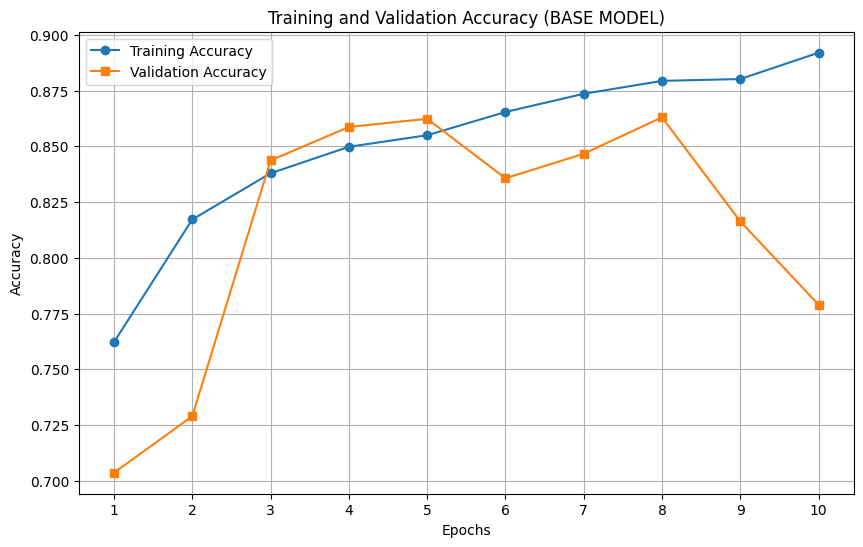

In [73]:
'''
Plot the training and validation accuracy over time (epochs).
'''

# Plotting training and validation accuracy over epochs

# BASE MODEL
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_accuracies_base) + 1), train_accuracies_base, label='Training Accuracy', marker='o')
plt.plot(range(1, len(valid_accuracies_base) + 1), valid_accuracies_base, label='Validation Accuracy', marker='s')
plt.title('Training and Validation Accuracy (BASE MODEL)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xticks(range(1, len(train_accuracies_base) + 1))
plt.legend()
plt.grid(True)
plt.show()

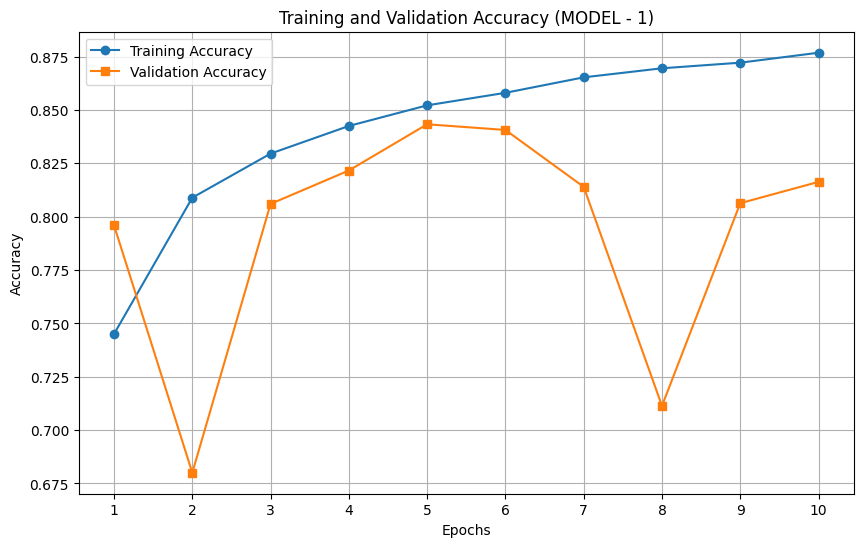

In [74]:
# MODEL - 1
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_accuracies_1) + 1), train_accuracies_1, label='Training Accuracy', marker='o')
plt.plot(range(1, len(valid_accuracies_1) + 1), valid_accuracies_1, label='Validation Accuracy', marker='s')
plt.title('Training and Validation Accuracy (MODEL - 1)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xticks(range(1, len(train_accuracies_1) + 1))
plt.legend()
plt.grid(True)
plt.show()

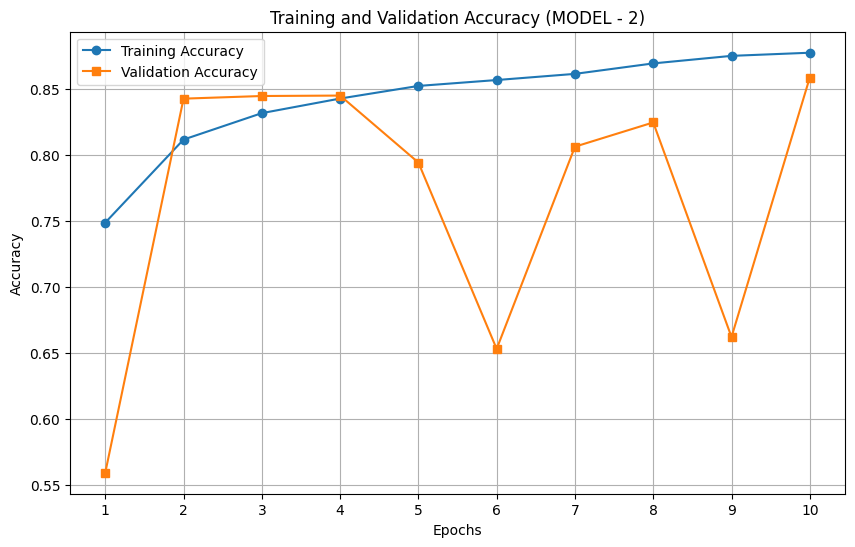

In [75]:
# MODEL - 2
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_accuracies_2) + 1), train_accuracies_2, label='Training Accuracy', marker='o')
plt.plot(range(1, len(valid_accuracies_2) + 1), valid_accuracies_2, label='Validation Accuracy', marker='s')
plt.title('Training and Validation Accuracy (MODEL - 2)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xticks(range(1, len(train_accuracies_2) + 1))
plt.legend()
plt.grid(True)
plt.show()

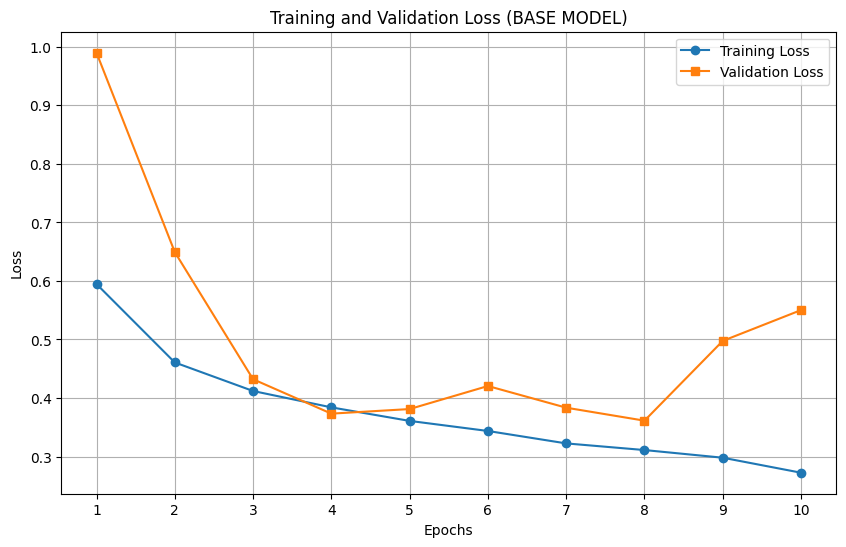

In [76]:
'''
Plot the training and validation loss over time (epochs).
'''

# BASE MODEL

# Plotting training and validation loss over epochs
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses_base) + 1), train_losses_base, label='Training Loss', marker='o')
plt.plot(range(1, len(valid_losses_base) + 1), valid_losses_base, label='Validation Loss', marker='s')
plt.title('Training and Validation Loss (BASE MODEL)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(range(1, len(train_losses_base) + 1))
plt.legend()
plt.grid(True)
plt.show()

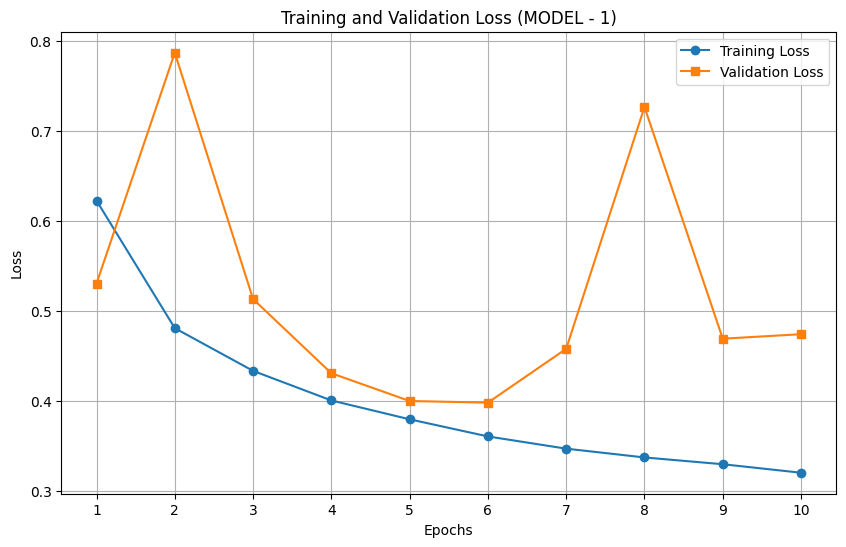

In [77]:
# MODEL - 1

# Plotting training and validation loss over epochs
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses_1) + 1), train_losses_1, label='Training Loss', marker='o')
plt.plot(range(1, len(valid_losses_1) + 1), valid_losses_1, label='Validation Loss', marker='s')
plt.title('Training and Validation Loss (MODEL - 1)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(range(1, len(train_losses_1) + 1))
plt.legend()
plt.grid(True)
plt.show()

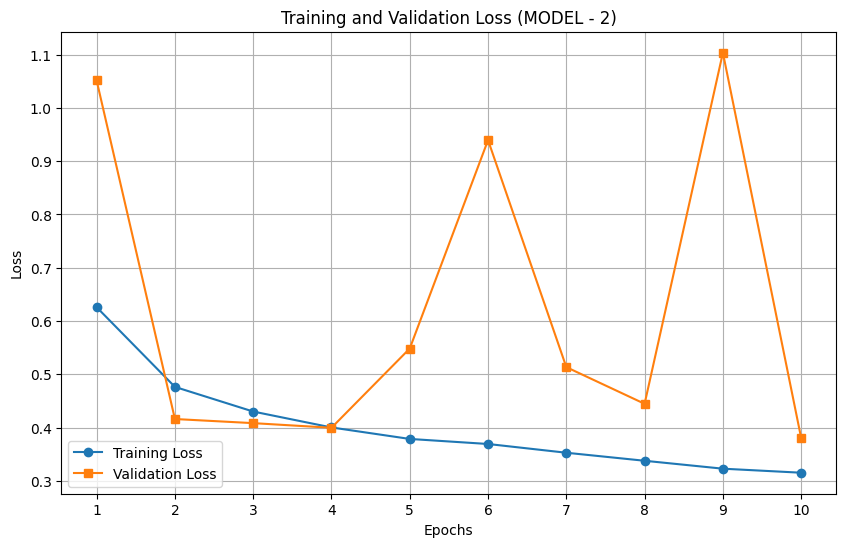

In [78]:
# MODEL - 2

# Plotting training and validation loss over epochs
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses_2) + 1), train_losses_2, label='Training Loss', marker='o')
plt.plot(range(1, len(valid_losses_2) + 1), valid_losses_2, label='Validation Loss', marker='s')
plt.title('Training and Validation Loss (MODEL - 2)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(range(1, len(train_losses_2) + 1))
plt.legend()
plt.grid(True)
plt.show()

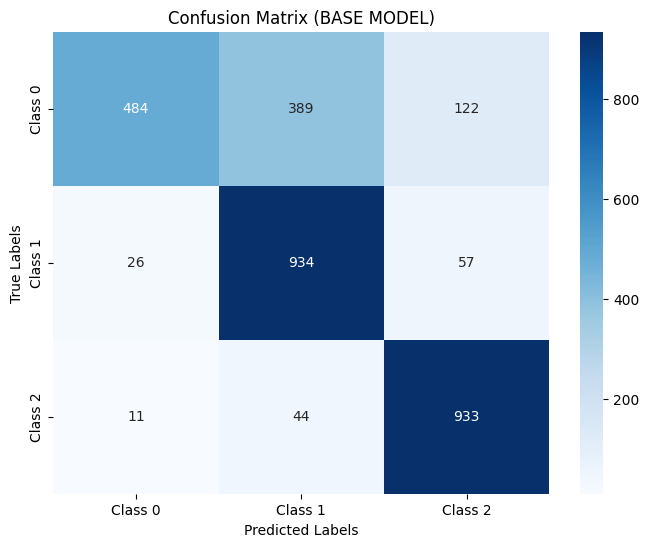

In [79]:
'''
Generate a confusion matrix using the model's predictions on the test set.
'''

from sklearn.metrics import confusion_matrix

# BASE MODEL

# Generating confusion matrix
conf_matrix_base = confusion_matrix(test_true_labels_base, test_predicted_labels_base)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_base, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1', 'Class 2'], yticklabels=['Class 0', 'Class 1', 'Class 2'])
plt.title('Confusion Matrix (BASE MODEL)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

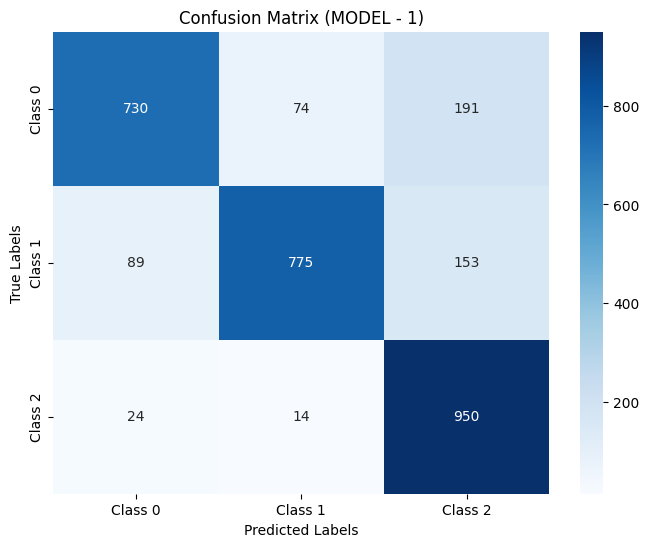

In [80]:
# MODEL - 1

# Generating confusion matrix
conf_matrix_1 = confusion_matrix(test_true_labels_1, test_predicted_labels_1)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_1, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1', 'Class 2'], yticklabels=['Class 0', 'Class 1', 'Class 2'])
plt.title('Confusion Matrix (MODEL - 1)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

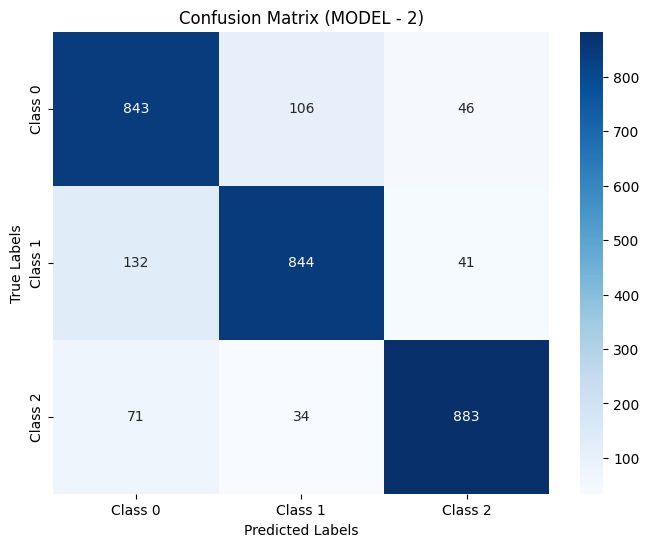

In [81]:
# MODEL - 2

# Generating confusion matrix
conf_matrix_2 = confusion_matrix(test_true_labels_2, test_predicted_labels_2)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_2, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1', 'Class 2'], yticklabels=['Class 0', 'Class 1', 'Class 2'])
plt.title('Confusion Matrix (MODEL - 2)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [82]:
'''
Calculate and report other evaluation metrics such as Precision, recall and F1
score (more details). You can use sklearn.metrics.precision_recall_fscore_support
'''

from sklearn.metrics import precision_recall_fscore_support

# BASE MODEL

# Calculating precision, recall, f1 score, and support
precision, recall, f1_score, _ = precision_recall_fscore_support(test_true_labels_base, test_predicted_labels_base, average='weighted')

# Printing the metrics
print("BASE MODEL 🔻\n")
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)

BASE MODEL 🔻

Precision: 0.81605381588381
Recall: 0.7836666666666666
F1 Score: 0.7700386345035084


In [83]:
# MODEL - 1

# Calculating precision, recall, f1 score, and support
precision_1, recall_1, f1_score_1, _ = precision_recall_fscore_support(test_true_labels_1, test_predicted_labels_1, average='weighted')

# Printing the metrics
print("MODEL - 1 🔻\n")
print("Precision:", precision_1)
print("Recall:", recall_1)
print("F1 Score:", f1_score_1)

MODEL - 1 🔻

Precision: 0.8334231822654414
Recall: 0.8183333333333334
F1 Score: 0.8171552513310498


In [84]:
# MODEL - 2

# Calculating precision, recall, f1 score, and support
precision_2, recall_2, f1_score_2, _ = precision_recall_fscore_support(test_true_labels_2, test_predicted_labels_2, average='weighted')

# Printing the metrics
print("MODEL - 2 🔻\n")
print("Precision:", precision_2)
print("Recall:", recall_2)
print("F1 Score:", f1_score_2)

MODEL - 2 🔻

Precision: 0.8578627168680076
Recall: 0.8566666666666667
F1 Score: 0.8569906110344321
